# Deep Generative Model

In this notebook we show how you can use the deep "generative model for semi-supervised learning" as presented in [[Kingma 2014]](https://arxiv.org/abs/1406.5298). The paper posits three different models, though we are just interested in two of these: the M2 model and the M1+M2 model.

The M1 model is just a variational autoencoder, so we refer to the previous notebook for more information on this. The M2 model however is an extension to the VAE to include label information for a semi-supervised objective. The structure is shown below (left: inference model, right: generative model).

<img src="../images/dgm.png" width="400px"/>

The point of the generative model is to seperate the partially observed label information $y$ from the latent variable $z$ in order to learn a representation that seperates these two variables. We can use this model for semi-supervised learning as the inference model must also infer the label from the data $x$ along with the latent variable $z$.

In [1]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")
from models import DeepGenerativeModel, StackedDeepGenerativeModel

Notice how theres now a classifier associated with model. This classifier will just be a simple model that takes the size of the first layer encoder network. We also have a larger input space on both the encoder and decoder to make room for label information, in this case 10 labels.


## Stacked Deep Generative Model

The M1+M2 model also described in the same paper is an M1 model (VAE) with an M2 model stacked on top of it. That means that we train the a VAE end-to-end on the data given dataset, then we use the learned encoder as a feature extractor and feed the data transformed by the M1 encoder into the M2 model.

We approach is somewhat similar to restricted boltzmann machines (RBMs) in the sense that we perform a layerwise training of the whole model by first training a level-1 feature extractor and stacking another model on top of this. The stacked model is therefore also more modular, but cannot be trained end-to-end, which is a downside.

In [2]:
from models import VariationalAutoencoder, StackedDeepGenerativeModel

features = VariationalAutoencoder([64 * 64 * 3, 300, [300]], conv=True, batch_norm=False).cuda()
stacked = StackedDeepGenerativeModel([64 * 64 * 3, 4, 50, [500]], features, batch_norm=False)
features.load_state_dict(torch.load("./vae_celeba_new.ckpt"))
model = stacked.dgm

../../semi-supervised/models/vae.py:237: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


300


../../semi-supervised/models/dgm.py:109: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


Typically, you would want to load a pretrained feature extractor VAE instead.

In [3]:
from datautils import get_celeba, get_mnist, get_svhn

labelled, unlabelled, validation, labels_names = get_celeba(location="./", batch_size=256, examples_num=None)

alpha = 0.1 * len(unlabelled)

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)
    # return -F.binary_cross_entropy(r, x, reduction="sum")

def mse(r, x):
    x = x.view(x.shape[0], -1)
    r = r.view(r.shape[0], -1)
    return torch.sum(torch.pow(x - r, 2), dim=-1)


In [4]:
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=0.5 / len(unlabelled))

# You can use importance weighted samples [Burda, 2015] to get a better estimate
# on the log-likelihood.
sampler = ImportanceWeightedSampler(mc=1, iw=1)

if cuda: model = model.cuda()
elbo = SVI(model, likelihood=mse)

In [5]:
from torch.autograd import Variable
from tqdm import tnrange


torch.multiprocessing.set_sharing_strategy('file_system')
features.eval()

for epoch in tnrange(150):
    model.train()
    total_loss, accuracy = (0, 0)
    idx = 0
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = Variable(x), Variable(y), Variable(u)
        

        if cuda:
            # They need to be on the same device and be synchronized.
            x, y = x.cuda(device=0), y.cuda(device=0)
            u = u.cuda(device=0)
        # _, z_x, _ = features.encoder(x)
        # _, z_u, _ = features.encoder(u)
        
        z_x, _, _ = features.encode(x)
        z_u, _, _ = features.encode(u)
        

        # print(x.shape)
        L = -elbo(z_x, y)
        U = -elbo(z_u)

        # Add auxiliary classification loss q(y|x)
        logits = model.classify(z_x)
        
        # Regular cross entropy
        classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

        # print("idx", idx, "L", L.item(), "U", U.item(), "class", classication_loss.item())
        J_alpha = L - alpha * classication_loss + U
        
        if torch.isnan(J_alpha):
            print(z_u)
            continue 
        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.item()
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        idx += 1
        
    if epoch % 5 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.4f}, accuracy: {:.4f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in validation:
            x, y = Variable(x), Variable(y)

            if cuda:
                x, y = x.cuda(device=0), y.cuda(device=0)

            # _, z_x _ = features.encode(x)
            z_x, _, _ = features.encode(x)
            
            L = -elbo(z_x, y)
            U = -elbo(z_x)

            logits = model.classify(z_x)
            classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classication_loss + U

            total_loss += J_alpha.item()

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(validation)
        print("[Validation]\t J_a: {:.4f}, accuracy: {:.4f}".format(total_loss / m, accuracy / m))

Epoch: 0
[Train]		 J_a: 659.3355, accuracy: 0.7022
[Validation]	 J_a: 662.0406, accuracy: 0.6086
Epoch: 5
[Train]		 J_a: 584.9996, accuracy: 0.9855
[Validation]	 J_a: 684.6344, accuracy: 0.6014
Epoch: 10
[Train]		 J_a: 580.0130, accuracy: 0.9961
[Validation]	 J_a: 712.3695, accuracy: 0.5907
Epoch: 15
[Train]		 J_a: 577.6119, accuracy: 0.9977
[Validation]	 J_a: 732.1612, accuracy: 0.5831
Epoch: 20
[Train]		 J_a: 576.3217, accuracy: 0.9982
[Validation]	 J_a: 741.0465, accuracy: 0.5797
Epoch: 25
[Train]		 J_a: 575.3973, accuracy: 0.9984
[Validation]	 J_a: 745.3557, accuracy: 0.5834
Epoch: 30
[Train]		 J_a: 574.3796, accuracy: 0.9988
[Validation]	 J_a: 750.4984, accuracy: 0.5773
Epoch: 35
[Train]		 J_a: 573.8870, accuracy: 0.9990
[Validation]	 J_a: 753.4951, accuracy: 0.5762
Epoch: 40
[Train]		 J_a: 573.2299, accuracy: 0.9990
[Validation]	 J_a: 757.2398, accuracy: 0.5723
Epoch: 45
[Train]		 J_a: 572.9409, accuracy: 0.9990
[Validation]	 J_a: 757.6824, accuracy: 0.5719
Epoch: 50
[Train]		 J_

In [6]:
model

DeepGenerativeModel(
  (encoder): Encoder(
    (first_dense): ModuleList(
      (0): Linear(in_features=300, out_features=500, bias=True)
      (1): Linear(in_features=4, out_features=500, bias=True)
    )
    (hidden): ModuleList(
      (0): ReLU()
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=500, out_features=50, bias=True)
      (log_var): Linear(in_features=500, out_features=50, bias=True)
    )
  )
  (decoder): Decoder(
    (first_dense): ModuleList(
      (0): Linear(in_features=50, out_features=500, bias=True)
      (1): Linear(in_features=4, out_features=500, bias=True)
    )
    (hidden): ModuleList(
      (0): ReLU()
    )
    (reconstruction): Linear(in_features=500, out_features=300, bias=True)
  )
  (classifier): Classifier(
    (first_dense): ModuleList(
      (0): Linear(in_features=300, out_features=500, bias=True)
    )
    (hidden): ModuleList(
      (0): ReLU()
    )
    (logits): Linear(in_features=500, out_features=4, bias=True)
  )
)

## Conditional generation

When the model is done training you can generate samples conditionally given some normal distributed noise $z$ and a label $y$.

*The model below has only trained for 10 iterations, so the perfomance is not representative*.

In [10]:
from utils import onehot
features.eval()
model.eval()

z_dim = 300
y_dim = 4

x, y = next(iter(validation))

_, z, _ = features.encode(x[10].unsqueeze(0).cuda())
_, z, _ = model.encoder(z)
z = z.repeat(40, 1)
print(z.shape)

# Generate a batch of 5s
ys = []
for y_idx in range(4):
    for step in range(10):
        interval = step / 9
        one_hot = [0] * y_dim
        one_hot[y_idx] = (1 - interval)
        one_hot[(y_idx + 1) % y_dim] = interval
        ys += [one_hot]
y = torch.tensor(ys).view(y_dim * 10, -1).cuda()

print(y.shape)


# z = torch.randn(5, 1, z_dim).repeat(1, 16, 1).reshape(5 * 16, z_dim).cuda()
# y = np.zeros((5, 16, 10))

# for y_idx in range(16):
#     y[:, y_idx, 4] = y_idx / 16
#     y[:, y_idx, 5] = 1 - (y_idx / 16)
# y = torch.tensor(y.reshape(5 * 16, 10)).cuda()
# x_mu = stacked.sample(z, y)

z_dim = 50
z = torch.randn(40, z_dim).repeat(1, 1).cuda()

# _, z, _ = features.encode(z)
# _, z, _ = model.encoder(z)

x_mu = stacked.sample(z, (y + 0.5).int())




torch.Size([40, 50])
torch.Size([40, 4])


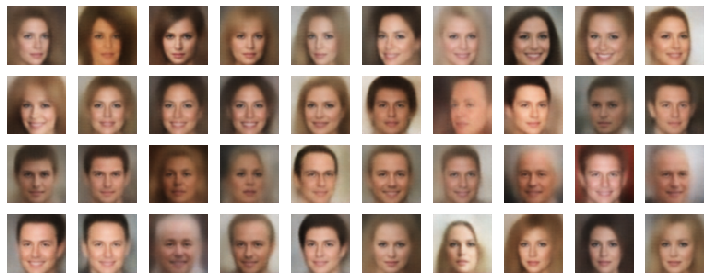

In [11]:
f, axarr = plt.subplots(4, 10, figsize=(10, 4))

samples = x_mu.data.view(-1, 3, 64, 64).cpu().numpy().transpose(0, 2, 3, 1)

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.set_xticks([])
    ax.set_yticks([])

    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# torch.save(model.state_dict(), "m1m2_celeba_new.ckpt")